In [1]:
import numpy as np
import pandas as pd
import matplotlib
import os
from matplotlib import image, pyplot as plt

In [2]:
def get_image_data(h_types, window, h_type_image_count, sub, rand=0):
    np.random.seed(rand)
    data = []
    labels = []
    num_images_list = [h_type_image_count for _ in range(len(h_types))] if isinstance(h_type_image_count, int) else h_type_image_count
    assert(len(num_images_list) == len(h_types))
    
    for h_type, num_images in zip(h_types, num_images_list):
        print(f'Starting {h_type}.')
        file_dir = f'dcms/renders/{h_type}/{h_type}/{window}/'
        img_names = np.array(os.listdir(file_dir))
        np.random.shuffle(img_names)
        if (n := len(img_names)) < num_images:
            print(f'You asked for {num_images}, but can only find {n} for {h_type}. Returning {n} images.')
        else:
            img_names = img_names[:num_images]

        ACTUAL_NUM_IMAGES = len(img_names)

        pulled_data = np.zeros([ACTUAL_NUM_IMAGES, int((512*512)/(sub ** 2))])

        for i, img in enumerate(img_names):
            if (i % 1000) == 0:
                print(f'{h_type}: {i}/{pulled_data.shape[0]}')
            im = np.mean(matplotlib.image.imread(file_dir + img),axis=2)
            if ((s := im.shape) != (512,512)):
                print(f'{img} not of correct dimensions (512,512). It is instead {s}. Removing image.')
                ACTUAL_NUM_IMAGES -= 1
                continue
            pulled_data[i,:] = im[::sub, ::sub].reshape(-1)
        
        data.append(pulled_data[:ACTUAL_NUM_IMAGES])
        labels.append(np.repeat(h_type, ACTUAL_NUM_IMAGES))
        print(f'Finished {h_type}.')
    
    return np.concatenate(data), np.concatenate(labels)

## Linear Regression

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
X_train, y_train = get_image_data(['normal', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'multi'] , 'brain_bone_window', 1000, 8, 1)
display(X_train.shape)
display(y_train.shape)

Starting normal.
normal: 0/1000
Finished normal.
Starting epidural.
epidural: 0/1000
Finished epidural.
Starting intraparenchymal.
intraparenchymal: 0/1000
Finished intraparenchymal.
Starting intraventricular.
intraventricular: 0/1000
Finished intraventricular.
Starting subarachnoid.
subarachnoid: 0/1000
Finished subarachnoid.
Starting subdural.
subdural: 0/1000
ID_176e4f16d.jpg not of correct dimensions (512,512). It is instead (638, 490). Removing image.
ID_b966185b8.jpg not of correct dimensions (512,512). It is instead (462, 462). Removing image.
ID_88b0d8b4f.jpg not of correct dimensions (512,512). It is instead (638, 490). Removing image.
ID_7a02fdbea.jpg not of correct dimensions (512,512). It is instead (666, 512). Removing image.
Finished subdural.
Starting multi.
multi: 0/1000
Finished multi.


(6996, 4096)

(6996,)

In [5]:
X_test, y_test = get_image_data(['normal','epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'multi'] , 'brain_bone_window', 100, 8, 123123)
display(X_test.shape)
display(y_test.shape)

Starting normal.
normal: 0/100
Finished normal.
Starting epidural.
epidural: 0/100
Finished epidural.
Starting intraparenchymal.
intraparenchymal: 0/100
Finished intraparenchymal.
Starting intraventricular.
intraventricular: 0/100
Finished intraventricular.
Starting subarachnoid.
subarachnoid: 0/100
Finished subarachnoid.
Starting subdural.
subdural: 0/100
Finished subdural.
Starting multi.
multi: 0/100
Finished multi.


(700, 4096)

(700,)

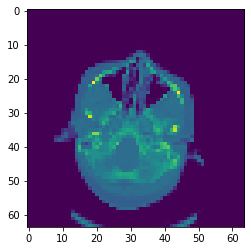

In [6]:
matplotlib.pyplot.imshow(X_train[0].reshape(int(X_train.shape[1]**.5),int(X_train.shape[1]**.5)))

### Convert label strings to int

In [7]:
y_train = np.where(y_train == "normal", 0, y_train)
y_train = np.where(y_train == "epidural", 1, y_train)
y_train = np.where(y_train == "intraparenchymal", 2, y_train)
y_train = np.where(y_train == "intraventricular", 3, y_train)
y_train = np.where(y_train == "multi", 4, y_train)
y_train = np.where(y_train == "subarachnoid", 5, y_train)
y_train = np.where(y_train == "subdural", 6, y_train)

y_train = y_train.astype('int')

In [8]:
y_test = np.where(y_test == "normal", 0, y_test)
y_test = np.where(y_test == "epidural", 1, y_test)
y_test = np.where(y_test == "intraparenchymal", 2, y_test)
y_test = np.where(y_test == "intraventricular", 3, y_test)
y_test = np.where(y_test == "multi", 4, y_test)
y_test = np.where(y_test == "subarachnoid", 5, y_test)
y_test = np.where(y_test == "subdural", 6, y_test)

y_test = y_test.astype('int')

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
## LBFGS

In [12]:
logReg = LogisticRegression(solver='lbfgs',max_iter=1000)
logReg.fit(X_train,y_train)

C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [13]:
y_pred = logReg.predict(X_test)

In [14]:
# Round to nearest label
y_pred = np.rint(y_pred)
y_pred = np.where(y_pred >6, 6, y_pred)
y_pred = np.where(y_pred <0, 0, y_pred)

In [15]:
RSS = 0
for i, item in enumerate(y_test):
    RSS += (y_test[i]-y_pred[i])**2
RSS

4166.0

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)


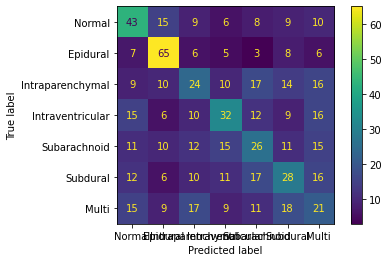

In [17]:
cmd = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Normal', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Multi'])

cmd.plot()

In [18]:
## SAG

In [19]:
logReg = LogisticRegression(solver='sag',max_iter=100)
logReg.fit(X_train,y_train)
y_pred = logReg.predict(X_test)
# Round to nearest label
y_pred = np.rint(y_pred)
y_pred = np.where(y_pred >6, 6, y_pred)
y_pred = np.where(y_pred <0, 0, y_pred)

C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [23]:
RSS = 0
for i, item in enumerate(y_test):
    RSS += (y_test[i]-y_pred[i])**2
RSS

4222.0

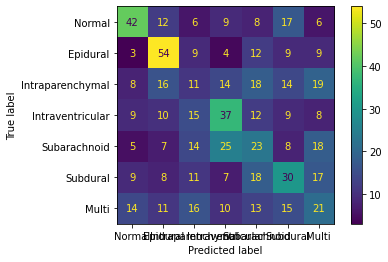

In [24]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cmd = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Normal', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Multi'])
cmd.plot()

In [20]:
## SAGA

In [28]:
logReg = LogisticRegression(solver='saga',max_iter=100)
logReg.fit(X_train,y_train)
y_pred = logReg.predict(X_test)
# Round to nearest label
y_pred = np.rint(y_pred)
y_pred = np.where(y_pred >6, 6, y_pred)
y_pred = np.where(y_pred <0, 0, y_pred)

C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [29]:
RSS = 0
for i, item in enumerate(y_test):
    RSS += (y_test[i]-y_pred[i])**2
RSS

4232.0

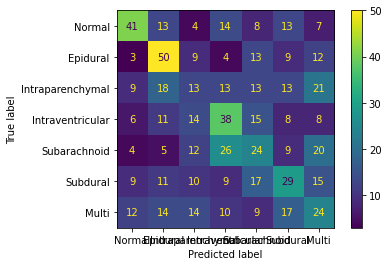

In [30]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cmd = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Normal', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Multi'])
cmd.plot()

In [34]:
## Newton-CG
logReg = LogisticRegression(solver='newton-cg',max_iter=100)
logReg.fit(X_train,y_train)
y_pred = logReg.predict(X_test)
# Round to nearest label
y_pred = np.rint(y_pred)
y_pred = np.where(y_pred >6, 6, y_pred)
y_pred = np.where(y_pred <0, 0, y_pred)

C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [32]:
RSS = 0
for i, item in enumerate(y_test):
    RSS += (y_test[i]-y_pred[i])**2
RSS

4230.0

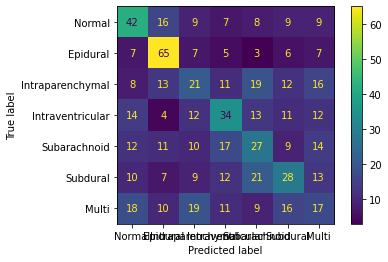

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cmd = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Normal', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Multi'])
cmd.plot()